In [ ]:
import geopandas as gpd
import pygadm
import atlite
import os
import logging
import yaml
from unidecode import unidecode
logging.basicConfig(level=logging.INFO)

dirname = os.getcwd() 
dirname = os.path.join(dirname, '..') #go one folder up to main dir of tool
with open(os.path.join(dirname, "configs/config.yaml"), "r", encoding="utf-8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)  

In [9]:
#config
region_name = config['region_name'] 
region_name_clean = unidecode(region_name)
region_name_clean = region_name_clean.replace(" ", "")
region_name_clean = region_name_clean.replace(".", "")
region_name_clean = region_name_clean.replace("'", "") 
region_name = region_name_clean
region_folder_name = config['region_folder_name']


data_path = os.path.join(dirname, 'data', region_folder_name)

#output directories
output_dir = os.path.join(dirname, 'data', f'{region_folder_name}')
os.makedirs(output_dir, exist_ok=True)
output_dir_weather_data = os.path.join(output_dir, 'weather_data')
os.makedirs(output_dir_weather_data, exist_ok=True)

#use GADM boundary
region_name = config['region_name'] #if country is studied, then use country name
country_code = config['country_code']  #3-digit ISO code  #PRT  #Städteregion Aachen in level 2 #Porto in level 1 #Elbe-Elster in level 2 #Zell am See in level 2
gadm_level = config['gadm_level']
#or use custom region
custom_polygon_filename = config['custom_polygon_filename'] #if None use empty string   

c:\Users\b396636\AppData\Local\anaconda3\envs\atlite\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
INFO:root:using admin area within country as study area


<Axes: >

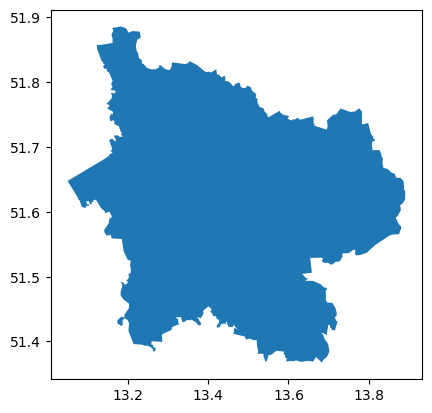

In [10]:
#get region boundary
if custom_polygon_filename:
    custom_polygon_filepath = os.path.join('input_data', custom_polygon_filename)
    region = gpd.read_file(custom_polygon_filepath)#, layer=layer_name)
    if region.crs != 4326:
        logging.warning('crs of custom polygon file for study region is not in EPSG 4326')
    logging.info('using custom polygon for study area')
elif gadm_level==0:
    gadm_data = pygadm.Items(admin=country_code)
    region = gadm_data
    region.set_crs('epsg:4326', inplace=True) #pygadm lib extracts information from the GADM dataset as GeoPandas GeoDataFrame. GADM.org provides files in coordinate reference system is longitude/latitude and the WGS84 datum.
    logging.info('using whole country as study area')
else:
    gadm_data = pygadm.Items(admin=country_code, content_level=gadm_level)
    region = gadm_data.loc[gadm_data[f'NAME_{gadm_level}']==region_name]
    region.set_crs('epsg:4326', inplace=True) #pygadm lib extracts information from the GADM dataset as GeoPandas GeoDataFrame. GADM.org provides files in coordinate reference system is longitude/latitude and the WGS84 datum.
    logging.info('using admin area within country as study area')

#region.to_file(os.path.join('data', f'{region_name}_4326.geojson'), driver='GeoJSON', encoding='utf-8')
region.plot()

In [11]:
#calculate bounding box with 1000m buffer (region needs to be in projected CRS so meters are the unit)
region_copy = region
region_copy.to_crs(epsg=4087, inplace=True) #epsg 4087 world equidistant cylindrical
region_copy['buffered']=region_copy.buffer(10000)
# Convert buffered region back to EPSC 4326 to get bounding box latitude and longitude 
region_buffered_4326 = region_copy.set_geometry('buffered').to_crs(epsg=4326)
bounding_box = region_buffered_4326['buffered'].total_bounds
print(f"Bounding box (EPSG:4326): \nminx: {bounding_box[0]}, miny: {bounding_box[1]}, maxx: {bounding_box[2]}, maxy: {bounding_box[3]}")

#cutout atlite needs x-slice (longitude) and y-slice (latitude)
x = (bounding_box[0], bounding_box[2])
y = (bounding_box[1], bounding_box[3])
print(x) 
print(y)

Bounding box (EPSG:4326): 
minx: 12.961181760716222, miny: 51.27783238027139, maxx: 13.980097523499976, maxy: 51.97593034640572
(12.961181760716222, 13.980097523499976)
(51.27783238027139, 51.97593034640572)


c:\Users\b396636\AppData\Local\anaconda3\envs\atlite\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\b396636\AppData\Local\anaconda3\envs\atlite\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# download cutout with atlite
adapt filename and year

In [12]:
#download settings
cutout = atlite.Cutout(
    path=os.path.join(output_dir_weather_data,f"{region_name}-2019-era5.nc"), #egypt-2019-wind-era5.nc
    module="era5", 
    x=slice(bounding_box[0], bounding_box[2]),  
    y=slice(bounding_box[1], bounding_box[3]),
    time="2019"
    #time=("2022-07-01","2023-06-30")
)

INFO:atlite.cutout:Building new cutout c:\Users\b396636\Documents\Turkiye_private\programming_turkiye\land_availability\weather data\..\data\Elbe-Elster\weather_data\Elbe-Elster-2019-era5.nc


In [ ]:
#download

#cutout.prepare(features=['wind'], monthly_requests=True, concurrent_requests=True, compression=None) 
#cutout.prepare(features=['influx', 'temperature'], monthly_requests=True, concurrent_requests=True, compression=None)

#progress: https://cds.climate.copernicus.eu/requests?tab=all

INFO:atlite.data:Storing temporary files in C:\Users\b396636\AppData\Local\Temp\tmp7jt53zgm
INFO:atlite.data:Calculating and writing with module era5:


INFO:atlite.datasets.era5:Requesting data for feature wind...
c:\Users\b396636\AppData\Local\anaconda3\envs\atlite\Lib\site-packages\cads_api_client\legacy_api_client.py:101: UserWarning: This is a beta version. The following parameters have not been implemented yet: {'info_callback': <bound method Logger.debug of <Logger atlite.datasets.era5 (INFO)>>}.
  warnings.warn(
2025-03-09 12:20:40,453 WARNING [2025-03-09T11:20:40.425082] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2025-03-09 12:20:40,456 INFO Request ID is 97875e8c-d3dd-47d1-bca7-bcc4f034f3cb
INFO:cads_api_client.processing:Request ID is 97875e8c-d3dd-47d1-bca7-bcc4f034f3cb
2025-03-09 12:20:40,484 WARNING [2025-03-09T11:20:40.463189] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2025-03-09 12:20:40,487 WARNING [2025-03-09T11:20:40.457666] You are using a deprecated API endpoint. If you are using cdsapi, please 

b36062afb5e0996bb4c922a11e796b47.nc:   0%|          | 0.00/173k [00:00<?, ?B/s]

2025-03-09 12:28:58,791 INFO status has been updated to running
INFO:cads_api_client.processing:status has been updated to running
2025-03-09 12:28:58,807 INFO status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful
INFO:atlite.datasets.era5:CDS: Downloading variables
	10m_u_component_of_wind (2019-12)
	10m_v_component_of_wind (2019-12)
	100m_u_component_of_wind (2019-12)
	100m_v_component_of_wind (2019-12)
	forecast_surface_roughness (2019-12)

INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-09/f539bab018cf73cea2fcfd7446103d3e.nc


f539bab018cf73cea2fcfd7446103d3e.nc:   0%|          | 0.00/179k [00:00<?, ?B/s]

2025-03-09 12:32:59,237 INFO status has been updated to running
INFO:cads_api_client.processing:status has been updated to running
2025-03-09 12:32:59,269 INFO status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful
INFO:atlite.datasets.era5:CDS: Downloading variables
	10m_u_component_of_wind (2019-9)
	10m_v_component_of_wind (2019-9)
	100m_u_component_of_wind (2019-9)
	100m_v_component_of_wind (2019-9)
	forecast_surface_roughness (2019-9)

INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-03-09/b696e62d4a8d0760dde4e8429f17a511.nc


b696e62d4a8d0760dde4e8429f17a511.nc:   0%|          | 0.00/175k [00:00<?, ?B/s]

2025-03-09 12:37:00,003 INFO status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful


ValueError: Result not ready, job is running

2025-03-09 12:39:00,246 INFO status has been updated to running
INFO:cads_api_client.processing:status has been updated to running
2025-03-09 12:41:00,500 INFO status has been updated to running
INFO:cads_api_client.processing:status has been updated to running
2025-03-09 12:41:00,500 INFO status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful
2025-03-09 12:45:00,979 INFO status has been updated to running
INFO:cads_api_client.processing:status has been updated to running
2025-03-09 12:45:00,993 INFO status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful
INFO:cads_api_client.processing:status has been updated to successful
INFO:cads_api_client.processing:status has been updated to running
INFO:cads_api_client.processing:status has been updated to successful
INFO:cads_api_client.processing:status has been updated to running
INFO:cads_api_client.processing:status has been updated to 